## Description:

    Use DeSeq2 to identify OTUs correlated with hydrolytic enzymes


# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3'

# Init

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "metagenomeSeq", "phyloseq", "dplyr", "tidyr", 
           "reshape", "vegan")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.4’
[1] "BiocParallel"
[1] ‘1.4.3’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.10.1’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.1.0’
[1] "gridExtra"
[1] ‘2.2.1’
[1] "scales"
[1] ‘0.4.0’
[1] "metagenomeSeq"
[1] ‘1.12.1’
[1] "phyloseq"
[1] ‘1.14.0’
[1] "dplyr"
[1] ‘0.5.0’
[1] "tidyr"
[1] ‘0.5.1’
[1] "reshape"
[1] ‘0.8.5’
[1] "vegan"
[1] ‘2.4.0’


In [4]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [5]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [7]:
%%R

#Set DAP as factor
sample_data(physeq.Full)$DAP = factor(sample_data(physeq.Full)$DAP) 
sample_data(physeq.Full)$Rep = factor(sample_data(physeq.Full)$Rep) 
sample_data(physeq.Full)$DAP %>% levels %>% print



[1] "36" "53" "57" "61" "72" "79" "84" "88"


# Test effect of CB within rhizosphere soil

In [6]:
%%R
## Create phyloseq object on subset of samples
physeq.plant = subset_samples(physeq.Full, Plant != "BARE")


## Create DESeq object and view results for Bare and Planted Seperately

In [36]:
%%R
#phy = subset_samples(physeq.plant, Type != "Maize" | Plant == "B73")

## ~DAP + CB_activity_g

In [9]:
%%R
phy = physeq.plant
dds = phyloseq_to_deseq2(phy, ~CB_activity_g)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

DF = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

CB.l2f = DF

[1] "Intercept"     "CB_activity_g"


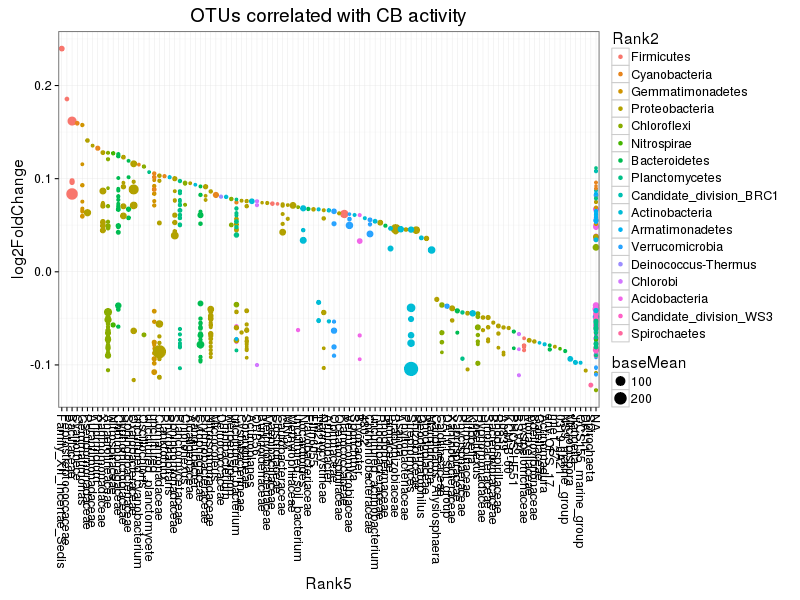

In [10]:
%%R -w 800 -h 600
sigtab = CB.l2f %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with CB activity")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x


p2

## ~Planted

In [12]:
%%R
## Create phyloseq object on subset of samples

phy = physeq.Full

#
dds = phyloseq_to_deseq2(phy, ~DAP + Planted)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

DF = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

rhiz.l2f = DF

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 77 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: fitting model and testing

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "Intercept"          "DAP"                "PlantedBARE"       
[4] "PlantedRhizosphere"


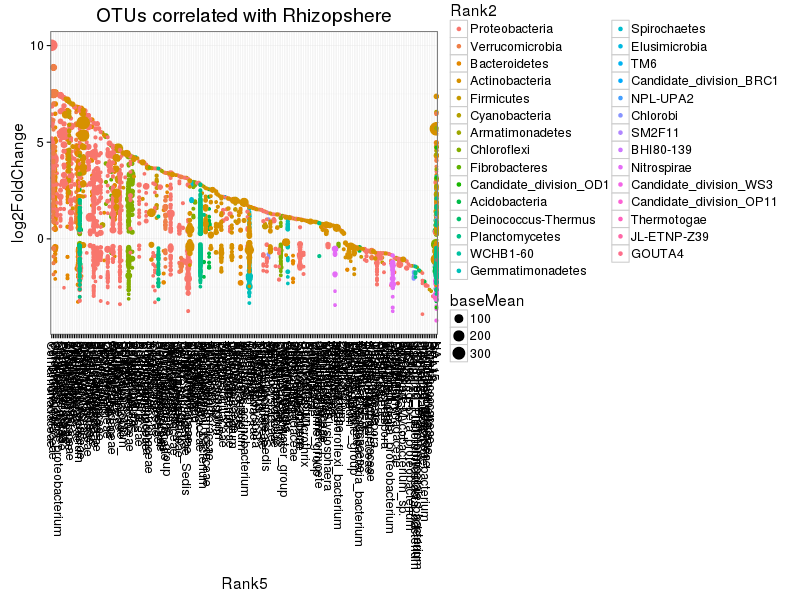

In [13]:
%%R -w 800 -h 600
sigtab = rhiz.l2f %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with Rhizopshere")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x


p2

# Compare OTUs responsible for both CB differences and who are enriched in the rhizosphere

In [15]:
%%R
colnames(CB.l2f)[c(2,6)] = c("CB.log2FoldChange", "CB.padj")
colnames(rhiz.l2f)[c(2,6)] = c("rhiz.log2FoldChange", "rhiz.padj")
head(CB.l2f)

          baseMean CB.log2FoldChange      lfcSE       stat    pvalue   CB.padj
OTU.4087 0.1610441      -0.033194325 0.02389350 -1.3892615 0.1647532 0.3860371
OTU.2009 0.6544488      -0.009067349 0.02378446 -0.3812300 0.7030326 0.8543540
OTU.5899 0.2060284       0.038168496 0.02585280  1.4763777 0.1398425 0.3519001
OTU.4181 0.1861910      -0.052421095 0.02609168 -2.0091116 0.0445253 0.1749939
OTU.3052 0.2624339      -0.005660393 0.02534164 -0.2233634 0.8232527 0.9234049
OTU.1890 0.7881296      -0.026962539 0.02026401 -1.3305625 0.1833330 0.4097176
            Rank1         Rank2                Rank3                     Rank4
OTU.4087 Bacteria           TM6 uncultured_bacterium                      <NA>
OTU.2009 Bacteria           TM6 uncultured_bacterium                      <NA>
OTU.5899 Bacteria Acidobacteria                32-21      uncultured_bacterium
OTU.4181 Bacteria Elusimicrobia          Lineage_IIa      uncultured_bacterium
OTU.3052 Bacteria Elusimicrobia          Lineage_IIa

In [17]:
%%R
comp = full_join(CB.l2f, rhiz.l2f[,c("OTU", "rhiz.log2FoldChange", "rhiz.padj")], by = "OTU")
head(comp)

   baseMean CB.log2FoldChange      lfcSE       stat    pvalue   CB.padj
1 0.1610441      -0.033194325 0.02389350 -1.3892615 0.1647532 0.3860371
2 0.6544488      -0.009067349 0.02378446 -0.3812300 0.7030326 0.8543540
3 0.2060284       0.038168496 0.02585280  1.4763777 0.1398425 0.3519001
4 0.1861910      -0.052421095 0.02609168 -2.0091116 0.0445253 0.1749939
5 0.2624339      -0.005660393 0.02534164 -0.2233634 0.8232527 0.9234049
6 0.7881296      -0.026962539 0.02026401 -1.3305625 0.1833330 0.4097176
     Rank1         Rank2                Rank3                     Rank4 Rank5
1 Bacteria           TM6 uncultured_bacterium                      <NA>  <NA>
2 Bacteria           TM6 uncultured_bacterium                      <NA>  <NA>
3 Bacteria Acidobacteria                32-21      uncultured_bacterium  <NA>
4 Bacteria Elusimicrobia          Lineage_IIa      uncultured_bacterium  <NA>
5 Bacteria Elusimicrobia          Lineage_IIa uncultured_soil_bacterium  <NA>
6 Bacteria Elusimicrobia    

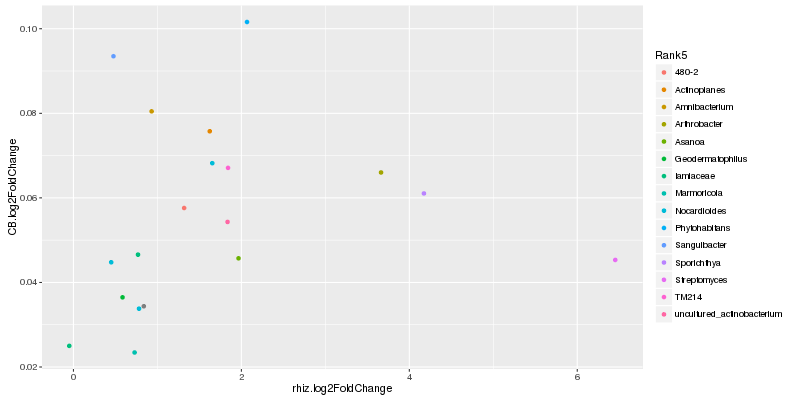

In [49]:
%%R -w 800 -h 400
comp %>%
    filter(CB.padj < 0.05 & CB.log2FoldChange > 0 & Rank2 == "Actinobacteria") %>%
    ggplot(aes(x = rhiz.log2FoldChange, y = CB.log2FoldChange, color = Rank5)) +
    geom_point()

In [40]:
%%R
dds = phyloseq_to_deseq2(phy, ~DAP + CB_activity_g)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

DF = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

 [1] "Intercept"     "DAP36"         "DAP53"         "DAP57"        
 [5] "DAP61"         "DAP72"         "DAP79"         "DAP84"        
 [9] "DAP88"         "CB_activity_g"


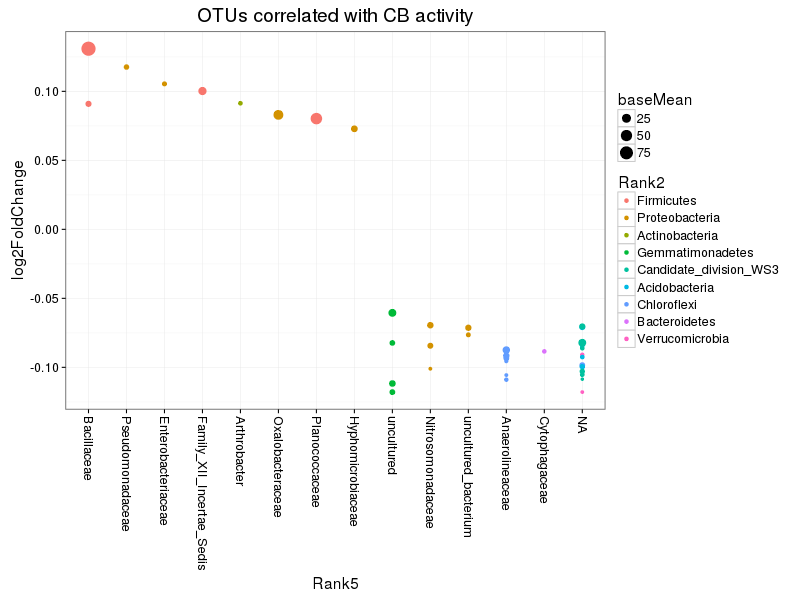

In [41]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with CB activity")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

In [42]:
%%R
dds = phyloseq_to_deseq2(phy, ~DAP + LAP_activity_g)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

DF = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

 [1] "Intercept"      "DAP36"          "DAP53"          "DAP57"         
 [5] "DAP61"          "DAP72"          "DAP79"          "DAP84"         
 [9] "DAP88"          "LAP_activity_g"


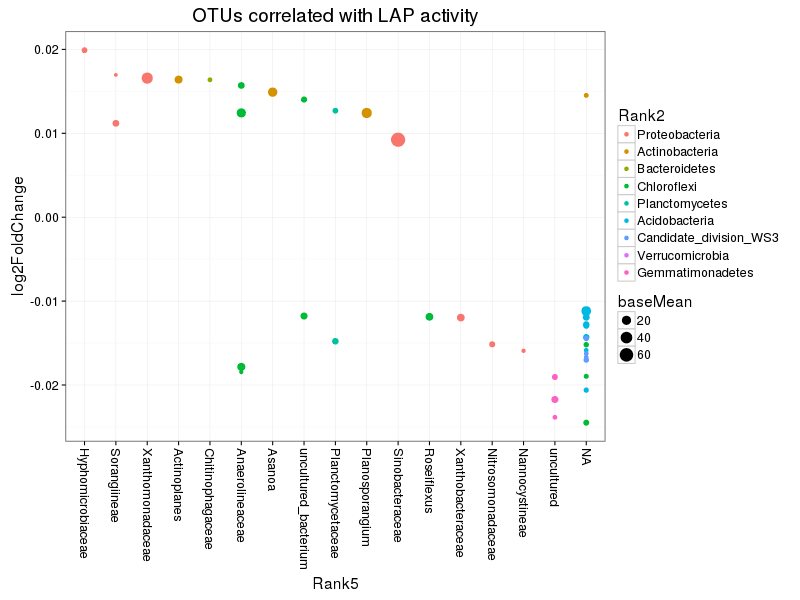

In [43]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
p3 = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with LAP activity")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p3

In [44]:
%%R
dds = phyloseq_to_deseq2(phy, ~Library + NAG_activity_g)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

DF = results(d_dds)

supp = tax_table(physeq.plant)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

[1] "Intercept"      "Library"        "NAG_activity_g"


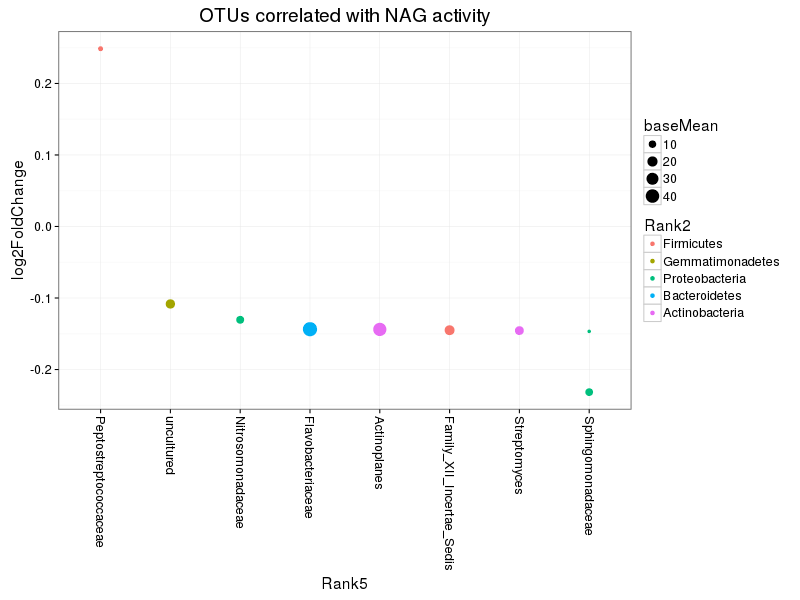

In [45]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
p3 = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with NAG activity")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p3

In [ ]:
%%R
bare_dds = phyloseq_to_deseq2(physeq.bare, ~DAP*Rep + Treatment)
bare_d_dds = DESeq(bare_dds, parallel = TRUE)
resultsNames(bare_d_dds)


In [ ]:
%%R
res = results(bare_d_dds, alpha = 0.1, parallel = TRUE)
summary(res)

* Not a single OTU is significantly enriched overall in bare soils with N treatment

## Bare ~ DAP:Rep + DAP:Treatment

In [ ]:
%%R
bare_dds = phyloseq_to_deseq2(physeq.bare, ~Rep + DAP + DAP:Treatment)
bare_d_dds = DESeq(bare_dds, parallel = TRUE)
resultsNames(bare_d_dds)


In [ ]:
%%R
res = results(bare_d_dds, alpha = 0.05, parallel = TRUE, contrast = c("Treatment", "Npos", "Nneg"))
summary(res)

In [ ]:
%%R
df = as.data.frame(res[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
    df$OTU = rownames(df)
    df = df[!is.na(df$padj),]

    TT = physeq.plant %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, by = 'OTU')
    

#df.sig = d[d$padj <0.05,]
#df.sig %>% arrange(padj) 

In [ ]:
%%R
asNumeric = function(x) { as.numeric(as.character(x)) }

## interested in both organisms that increase or decrease in abundance
get_Ps = function(physeq.obj, l2fc_threshold) {
    diagdds = phyloseq_to_deseq2(physeq.obj, ~Rep + Treatment)
    diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)
    r = results(diagdds, lfcThreshold = l2fc_threshold, independentFiltering = TRUE)
    df = as.data.frame(res[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
    df$OTU = rownames(df)

    TT = physeq.obj %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, c('OTU'))
    return(d)
}

#Function to trim physeq object to just samples to include in Deseq analysis
deseq_prune = function(physeq.obj, plant, day) {
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Plant %in% c("BARE", plant))&
                     (physeq.md$DAP == day), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > 0, TRUE)
    return(p.thresh)
}

## Define deseq object Full dataset

In [ ]:
%%R
diagdds = phyloseq_to_deseq2(physeq, ~DAP + PlantRep + Treatment)
diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)

In [ ]:
%%R
res = results(diagdds, parallel = TRUE, independentFiltering = TRUE)

In [ ]:
%%R    
    theta = 0.5
    beta = res$log2FoldChange
    betaSE = res$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    res$p = p
    df = as.data.frame(res[, c("baseMean", "log2FoldChange", "p")])
    df$p.adj = p.adjust(df$p, "BH")

df$OTU = rownames(df)

    TT = physeq.Full %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, c('OTU'))
    d %>% head %>% print

In [ ]:
%%R
summary(res)

### Model only results in one marginally significant OTU - 
Proteobacteria Betaproteobacteria Burkholderiales Comamonadaceae

## Deseq analysis on just the plants

Note that model with DAP is not full rank so it cannot run with DAP as a controlling factor

In [ ]:
%%R
diagdds = phyloseq_to_deseq2(physeq.plant, ~ PlantRep + Treatment)
diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)

In [ ]:
%%R
res = results(diagdds, parallel = TRUE, independentFiltering = TRUE)

In [ ]:
%%R
summary(res)

In [ ]:
%%R    
    theta = 0.5
    beta = res$log2FoldChange
    betaSE = res$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    res$p = p
    df = as.data.frame(res[, c("baseMean", "log2FoldChange", "p")])
    df$p.adj = p.adjust(df$p, "BH")

df$OTU = rownames(df)

    TT = physeq.Full %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, c('OTU'))
    d %>% head %>% print

In [ ]:
%%R -w 800 -h 600
sigtab = d[d$p.adj < .05,]
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2)) + geom_point(size=5) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

## Create Deseq object for just the bare soils

In [ ]:
%%R
## Create phyloseq object on subset of samples
physeq.bare = subset_samples(physeq.Full, Plant == "BARE")
sample_data(physeq.bare)$DAPRep = interaction(sample_data(physeq.bare)$DAP, sample_data(physeq.bare)$Rep)

In [ ]:
%%R
diagdds = phyloseq_to_deseq2(physeq.bare, ~ DAPRep + Treatment)
diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)

In [ ]:
%%R
res = results(diagdds, parallel = TRUE, independentFiltering = TRUE)

In [ ]:
%%R
summary(res)

In [ ]:
%%R    
    theta = 0.0
    beta = res$log2FoldChange
    betaSE = res$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    res$p = p
    df = as.data.frame(res[, c("baseMean", "log2FoldChange", "p")])
    df$p.adj = p.adjust(df$p, "BH")

df$OTU = rownames(df)

    TT = physeq.Full %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, c('OTU'))
    d %>% head %>% print

In [ ]:
%%R
sigtab

In [ ]:
%%R -w 800 -h 600
sigtab = d[d$p.adj < .05,]
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2)) + geom_point(size=5) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))

## Test other N status indicators

In [ ]:
%%R
physeq.d15N = subset_samples(physeq.Full, !is.na(d15N))
physeq.d15N

In [ ]:
%%R
diagdds = phyloseq_to_deseq2(physeq.d15N, ~ d15N)
diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)

In [ ]:
%%R
res = results(diagdds, parallel = TRUE, independentFiltering = TRUE)

In [ ]:
%%R
head(res)

In [ ]:
%%R    
#
    #theta = 0.0
    #beta = res$log2FoldChange
    #betaSE = res$lfcSE
    #p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    #res$p = p
    df = as.data.frame(res[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
    

df$OTU = rownames(df)

    TT = physeq.Full %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, c('OTU'))
    d %>% head %>% print

In [ ]:
%%R
sigtab = d[d$padj < .05,]
dim(sigtab)

In [ ]:
%%R -w 800 -h 600
sigtab = d[d$padj < .05,]
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2)) + geom_point(size=5) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))